In [3]:
import proplot as pplt
import numpy as np
# import matplotlib.pyplot as plt


In [73]:
from astropy.coordinates import EarthLocation, get_sun
from astropy.time import Time

mjd0 = 60796.0  # 60796 = May 10, 2025


def survey_start_mjd():
    """A place to store the expected MJD start time of the survey."""
    return mjd0


def calc_season_footprint(ra, mjd_in, mjd_start=None):
    # A reference time and sun RA location to anchor the location of the Sun
    # This time was chosen as it is close to the expected start of the survey.
    if mjd_start is None:
        ref_time = survey_start_mjd()
    else:
        ref_time = mjd_start
    from astropy.time import Time
    from astropy.coordinates import get_sun
    from astropy.coordinates import EarthLocation
    loc = EarthLocation.of_site('Cerro Pachon')
    t = Time(ref_time, format='mjd', location=loc)
    sun_ra_start = get_sun(t).ra.deg

    period = 365.25
    phase = ((-ra + sun_ra_start) / 180.0 * np.pi) % (2.0 * np.pi)
    phase = phase * (period / 2.0 / np.pi)

    t = mjd_in - ref_time + phase
    season = np.floor(t / (period))
    season = season.astype(int)
    
    # # Calculate the fraction of the sphere/"year" for this location
    # offset = (ra - ref_sun_ra) / 360 * 365.25
    # # Calculate when the seasons should begin
    # season_began = ref_time + offset
    # # Calculate the season value for each point.
    # seasons = (time - season_began) / 365.25

    # # Calculate the fraction of the sphere/"year" for this location
    # ref_RA = 360.0
    # offset = (ref_RA - ref_sun_ra) / 360 * 365.25
    # # Calculate when the seasons should begin
    # season_began = ref_time + offset
    # # Calculate the season value for each point.
    # min_season = (ref_time - season_began) / 365.25
    # min_season = np.floor(min_season)
    
    # # (usually) Set first season at this point to 0
    # seasons = seasons - min_season
    return season
    # The reference values can be evaluated using:
    # from astropy.time import Time
    # from astropy.coordinates import get_sun
    # from astropy.coordinates import EarthLocation
    # loc = EarthLocation.of_site('Cerro Pachon')
    # t = Time('2024-09-22T00:00:00.00', format='isot', scale='utc', location=loc)
    # print('Ref time', t.utc.mjd)
    # print('Ref sun RA', get_sun(t).ra.deg, t.utc.mjd)
    # print('local sidereal time at season start', t.sidereal_time('apparent').deg)


0.0
0.0


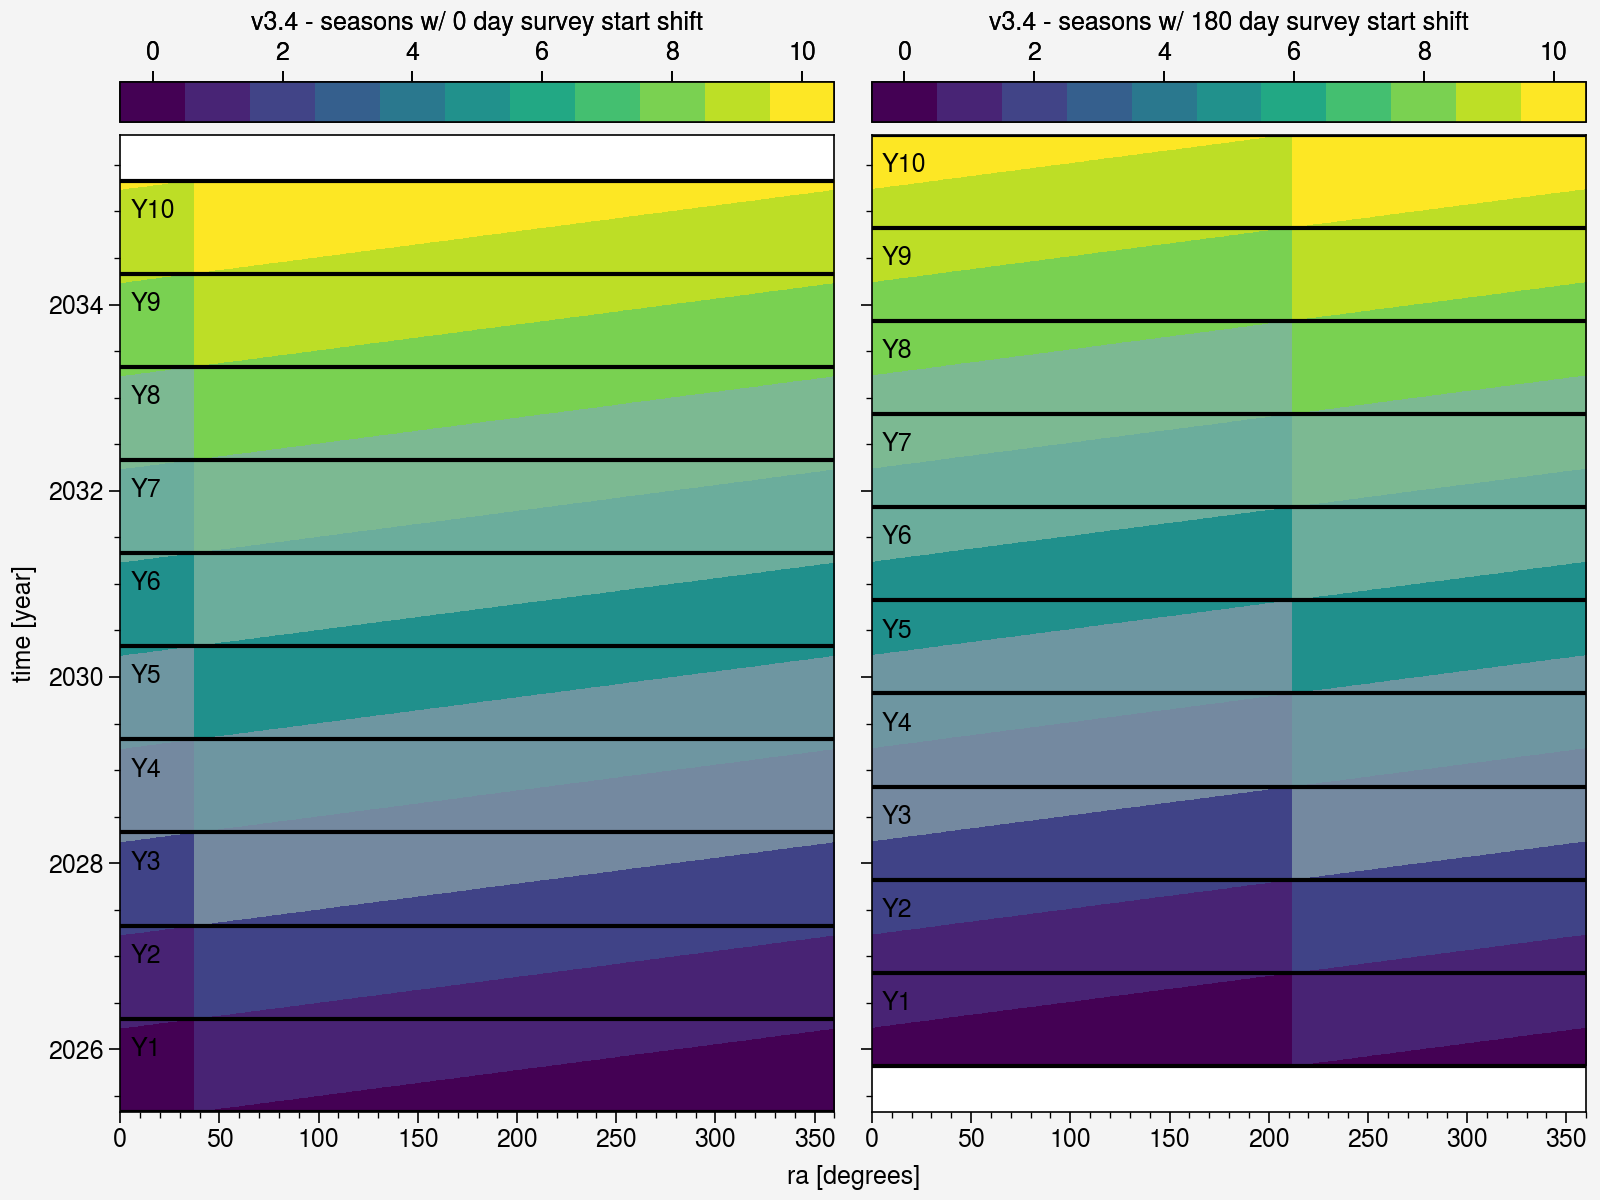

In [75]:
def _plot_for_shift(shift, ax, func, label):
    start_time = survey_start_mjd() + shift
    year = 365.25
    run_time = year * 10.0
    time_grid = np.linspace(start_time, start_time + run_time, int(run_time / year) * 1000 + 1)
    tv = (time_grid[:-1] + time_grid[1:])/2.0
    ra_grid = np.linspace(0, 360, 24*10 + 1)
    rav = (ra_grid[:-1] + ra_grid[1:])/2.0    
    
    seasons = func(
        rav.reshape(1, -1), tv.reshape(-1, 1),
        mjd_start=start_time,
    )
    
    iseasons = np.floor(seasons)
    print(iseasons.min())
    levels = np.arange(int(iseasons.min()), int(iseasons.max()) + 2) - 0.5
    values = (levels[:-1] + levels[1:])/2

    pvals = np.zeros_like(iseasons)
    pvals[:, :] = np.nan
    # 111UD1UDUD111
    
    for rseas in [3, 4, 6, 7]:
        pvals[iseasons == rseas] = 1

    loc = EarthLocation.of_site("Cerro Pachon")
    t = Time("2024-01-01T00:00:00.00", format="isot", scale="utc", location=loc)
    ref_2024 = t.utc.mjd / year - 2024
    
    m = ax.pcolorfast(
        ra_grid, time_grid / year - ref_2024, iseasons,
        levels=levels,
        cmap="viridis",
    )
    ax.pcolorfast(
        ra_grid, time_grid / year - ref_2024, pvals,
        # levels=levels,
        cmap="grays",
        alpha=0.5,
    )
    ax.colorbar(
        m, 
        loc="t", 
        title=f"{label} - seasons w/ {shift} day survey start shift", 
        ticks=values,
    )
    for i in range(int(run_time/year)):
        yloc = start_time / year - ref_2024 + i
        ax.axhline(yloc, color="k")
        ax.text(5.0, yloc + 0.6, "Y%d" % (i+1))
    ax.axhline((start_time + run_time) / year - ref_2024, color="k")    
    ax.format(
        xlabel="ra [degrees]",
        ylabel="time [year]",
        xlim=(0, 360),
        grid=False
    )
    # ax.axvline(ref_sun_ra, color="k", linestyle="dashed")


fig, axs = pplt.subplots(nrows=1, ncols=2, figsize=(8, 6))

_plot_for_shift(0, axs[0, 0], calc_season_footprint, "v3.4")
_plot_for_shift(180, axs[0, 1], calc_season_footprint, "v3.4")

# _plot_for_shift(0, axs[1, 0], calc_season_matt, "matt")
# _plot_for_shift(180, axs[1, 1], calc_season_matt, "matt")

t/period: [ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75
  3.    3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75
  6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.  ]
season: [ 0  0  0  0  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  4  5  5  5  5
  6  6  6  6  7  7  7  7  8  8  8  8  9  9  9  9 10]
plateaus: [ 0.   0.   0.   0.   1.   1.   1.   1.   2.   2.   2.   2.   2.1  2.1
  2.1  2.1  4.   4.   4.   4.   4.1  4.1  4.1  4.1  6.   6.   6.   6.
  6.1  6.1  6.1  6.1  8.   8.   8.   8.   9.   9.   9.   9.  10. ]
step_inds [ 3  7 11 15 19 23 27 31 35 39]
result: [ 0.    0.    0.    0.5   1.    1.    1.    1.5   2.    2.    2.    2.05
  2.1   2.1   2.1   3.05  4.    4.    4.    4.05  4.1   4.1   4.1   5.05
  6.    6.    6.    6.05  6.1   6.1   6.1   7.05  8.    8.    8.    8.5
  9.    9.    9.    9.5  10.  ]


<a list of 1 Line2D objects>

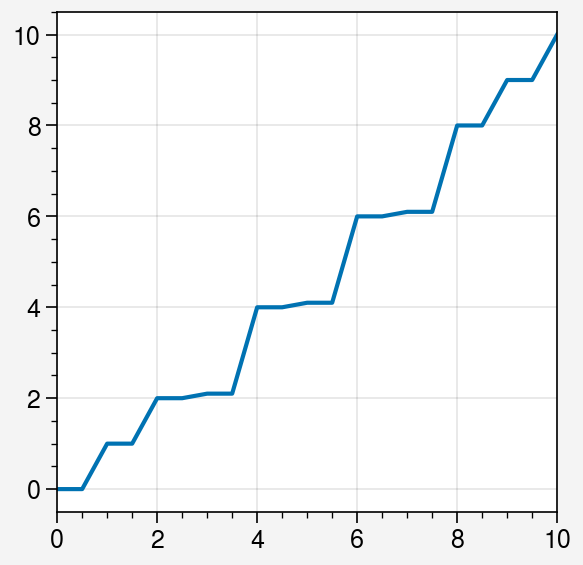

In [275]:
period = 365.25
rise = [1.0, 1.0, 1.0, 0.1, 1.9, 0.1, 1.9, 0.1, 1.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

def _fun(mjd_in, phase, verbose=False):
    steps = np.array(rise)
    t = mjd_in + phase
    if verbose:
        print("t/period:", t / period)
    season = np.floor(t / (period))
    season = season.astype(int)
    if verbose:
        print("season:", season)
    
    plateus = np.cumsum(steps) - steps[0]
    
    result = plateus[season]
    if verbose:
        print("plateaus:", result)
    tphased = t % period
    step_inds = np.where(tphased > period / 2.0)[0]
    if verbose:
        print("step_inds", step_inds)
    result[step_inds] += (
        (tphased[step_inds] - period / 2) * steps[season + 1][step_inds] / (0.5 * period)
    )
    result[np.where(t < 0)] = 0
    if verbose:
        print("result:", result)
    return result

mjd_in = np.linspace(0, 10, 41) * period
phase = 0
phase *= period

res = _fun(mjd_in, phase, verbose=True) - _fun(np.array([0]), phase)

fig, axs = pplt.subplots()
axs.plot(mjd_in / period, res)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.] [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5]


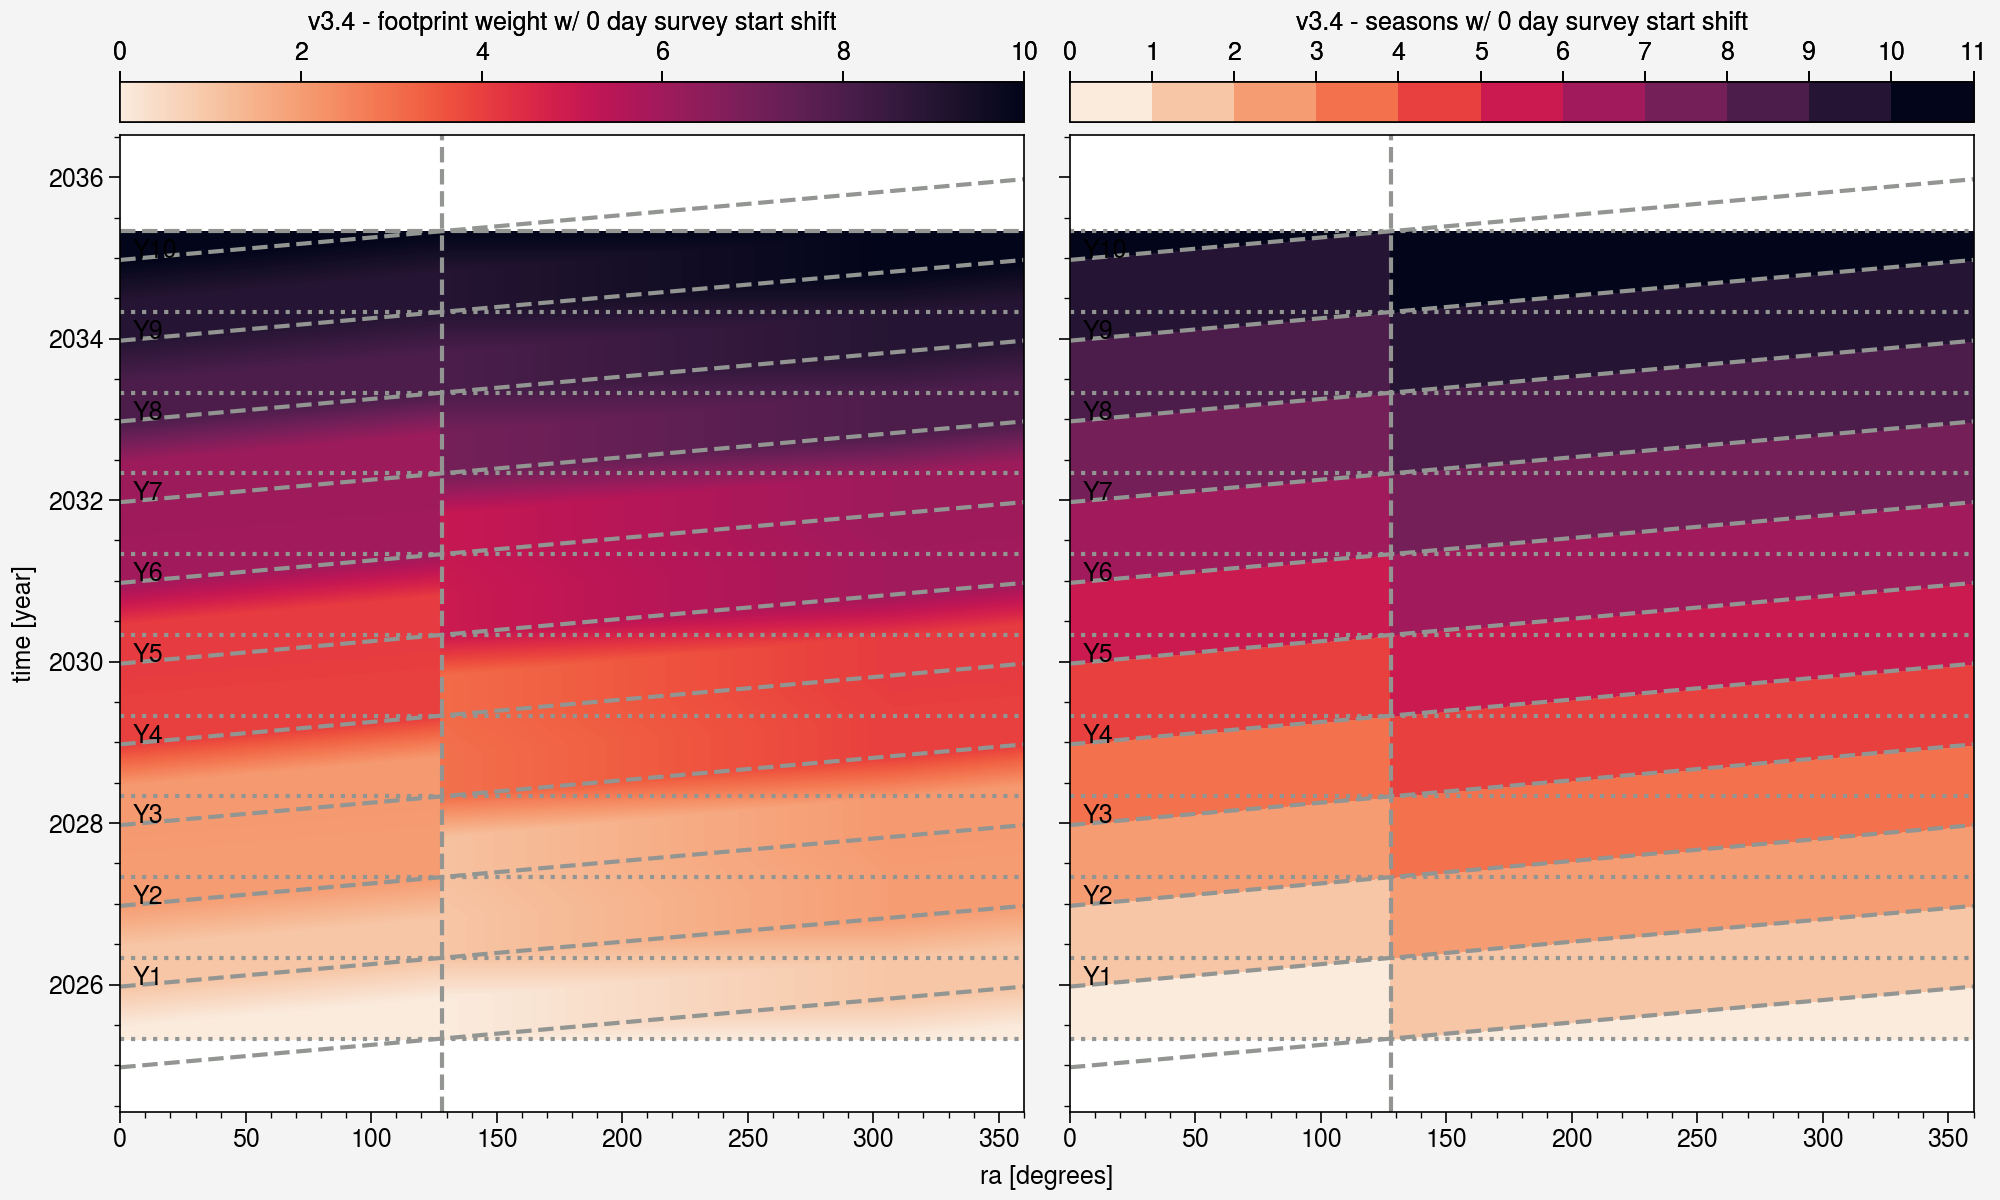

In [280]:
def _plot_for_shift(shift, ax, axs, label):
    from astropy.time import Time
    from astropy.coordinates import get_sun
    from astropy.coordinates import EarthLocation

    year = 365.25

    loc = EarthLocation.of_site("Cerro Pachon")
    t = Time("2024-01-01T00:00:00.00", format="isot", scale="utc", location=loc)
    ref_2024 = t.utc.mjd / year - 2024
    
    start_time = survey_start_mjd() + shift
    num_years = 10
    run_time = year * num_years
    time_grid = np.linspace(start_time, start_time + run_time, int(run_time / year) * 1000 + 1)
    tv = (time_grid[:-1] + time_grid[1:])/2.0
    ra_grid = np.linspace(0, 360, 24*10 + 1)
    rav = (ra_grid[:-1] + ra_grid[1:])/2.0

    loc = EarthLocation.of_site('Cerro Pachon')
    t = Time(start_time, format='mjd', location=loc)
    sun_ra_start = get_sun(t).ra.deg
    
    phase = (
        ((sun_ra_start - rav) / 180 * np.pi + np.pi / 2) % (2.0 * np.pi)
        * (year / 2.0 / np.pi)
    )

    seasons = (
        (tv.reshape(-1, 1) - start_time + phase.reshape(1, -1)) / year
    )

    phase_0 = (
        ((sun_ra_start - 0) / 180 * np.pi + np.pi / 2) % (2.0 * np.pi)
        * (year / 2.0 / np.pi)
    )
    
    phase_360 = (
        ((sun_ra_start - 360) / 180 * np.pi + np.pi / 2) % (2.0 * np.pi)
        * (year / 2.0 / np.pi)
    )
    
    season_left = year - phase_0
    season_right = 2*year - phase_360
    
    obs_ints = np.zeros((rav.shape[0], tv.shape[0])).T
    for i in range(rav.shape[0]):
        obs_ints[:, i] = _fun(
            tv - start_time,
            phase[i],
        ) - _fun(np.zeros_like(tv), phase[i])
    
    max_obs_ints = int(np.ceil(obs_ints.max()))
    # assert np.allclose(max_obs_ints, num_years)
    # per_season_levels = np.array([0, 0.25, 0.75])
    # levels = []
    # for i in range(max_season):
    #     levels.extend((per_season_levels + i).tolist())
    # levels = np.array(levels)

    m = ax.pcolormesh(
        ra_grid, time_grid / year - ref_2024, obs_ints,
        vmin=0,
        vmax=max_obs_ints,
        shading="flat",
        # N=max_obs_ints*8,
        cmap="rocket_r",
        discrete=False,
    )
    
    ax.colorbar(
        m, 
        loc="t", 
        title=f"{label} - footprint weight w/ {shift} day survey start shift", 
    )
    i = -1
    ax.plot(
        [0, 360], 
        [(year * i + season_left + start_time) / year - ref_2024, 
         (year * i + season_right + start_time) / year - ref_2024], 
        color="gray", 
        linestyle="dashed",
    )
    
    for i in range(int(run_time/year)):
        yloc = start_time / year - ref_2024 + i
        ax.axhline(yloc, color="gray", linestyle="dotted")
        # ax.axhline(yloc + 0.25, color="gray", linestyle="dotted")
        # ax.axhline(yloc + 0.5, color="gray", linestyle="dotted")
        # ax.axhline(yloc + 0.75, color="gray", linestyle="dotted")
        ax.plot(
            [0, 360], 
            [(year * i + season_left + start_time) / year - ref_2024, 
             (year * i + season_right + start_time) / year - ref_2024], 
            color="gray", 
            linestyle="dashed",
        )
        
        ax.text(5.0, yloc + 0.9, "Y%d" % (i+1), ha="left", va="top")
    ax.axhline((start_time + run_time) / year - ref_2024, color="gray", linestyle="dashed")    
    ax.axvline(sun_ra_start + 90, color="gray", linestyle="dashed")
    ax.format(
        xlabel="ra [degrees]",
        ylabel="time [year]",
        xlim=(0, 360),
        grid=False,
        # ylim=((start_time - ref_2024)/year, (start_time + run_time - ref_2024)/year),
    )
    # ax.axvline(ref_sun_ra, color="k", linestyle="dashed")

    levels = np.linspace(0, num_years+1, (num_years+1) * 1 + 1)
    values = (levels[:-1] + levels[1:])/2
    print(levels, values)
    
    m = axs.pcolormesh(
        ra_grid, time_grid / year - ref_2024, seasons,
        levels=levels,
        cmap="rocket_r",
    )
    axs.colorbar(
        m, 
        loc="t", 
        title=f"{label} - seasons w/ {shift} day survey start shift", 
        ticks=levels,
    )
    i = -1
    axs.plot(
        [0, 360], 
        [(year * i + season_left + start_time) / year - ref_2024, 
         (year * i + season_right + start_time) / year - ref_2024], 
        color="gray", 
        linestyle="dashed",
    )
    
    for i in range(int(run_time/year)):
        yloc = start_time / year - ref_2024 + i
        axs.axhline(yloc, color="gray", linestyle="dotted")
        axs.plot(
            [0, 360], 
            [(year * i + season_left + start_time) / year - ref_2024, 
             (year * i + season_right + start_time) / year - ref_2024], 
            color="gray", 
            linestyle="dashed",
        )
        
        axs.text(5.0, yloc + 0.9, "Y%d" % (i+1), ha="left", va="top")
    axs.axhline((start_time + run_time) / year - ref_2024, color="gray", linestyle="dotted")    
    axs.axvline(sun_ra_start + 90, color="gray", linestyle="dashed")
    axs.format(
        xlabel="ra [degrees]",
        ylabel="time [year]",
        xlim=(0, 360),
        grid=False,
        # ylim=((start_time - ref_2024 * year)/year, (start_time + run_time - ref_2024 * year)/year),
    )
    return obs_ints, rav, tv


fig, axs = pplt.subplots(nrows=1, ncols=2, figsize=(10, 6))

obs_ints, rav, tv = _plot_for_shift(0, axs[0, 0], axs[0, 1], "v3.4")
# _plot_for_shift(180, axs[1, 0], axs[1, 1], "v3.4");
# _plot_for_shift(180, axs[0, 1], "v3.4")

# _plot_for_shift(0, axs[1, 0], calc_season_matt, "matt")
# _plot_for_shift(180, axs[1, 1], calc_season_matt, "matt")

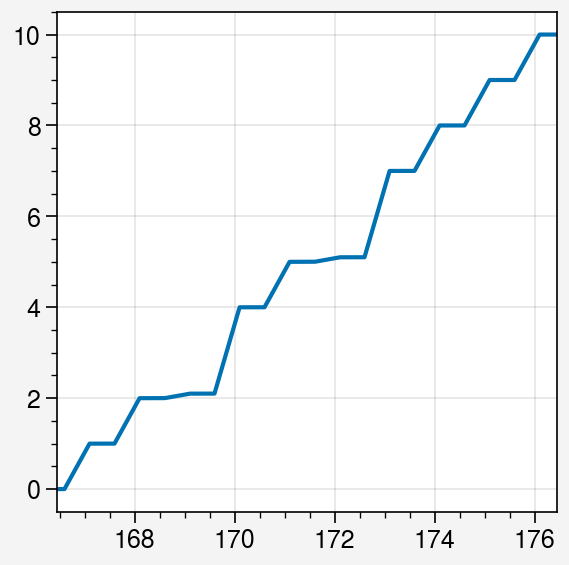

In [269]:
nra = obs_ints.shape[1]
fig, axs = pplt.subplots()
for i in range(nra):
    assert np.all(obs_ints[1:, i] - obs_ints[:-1, i] >= 0)
    axs.plot(tv/365.25, obs_ints[:, i])
    break

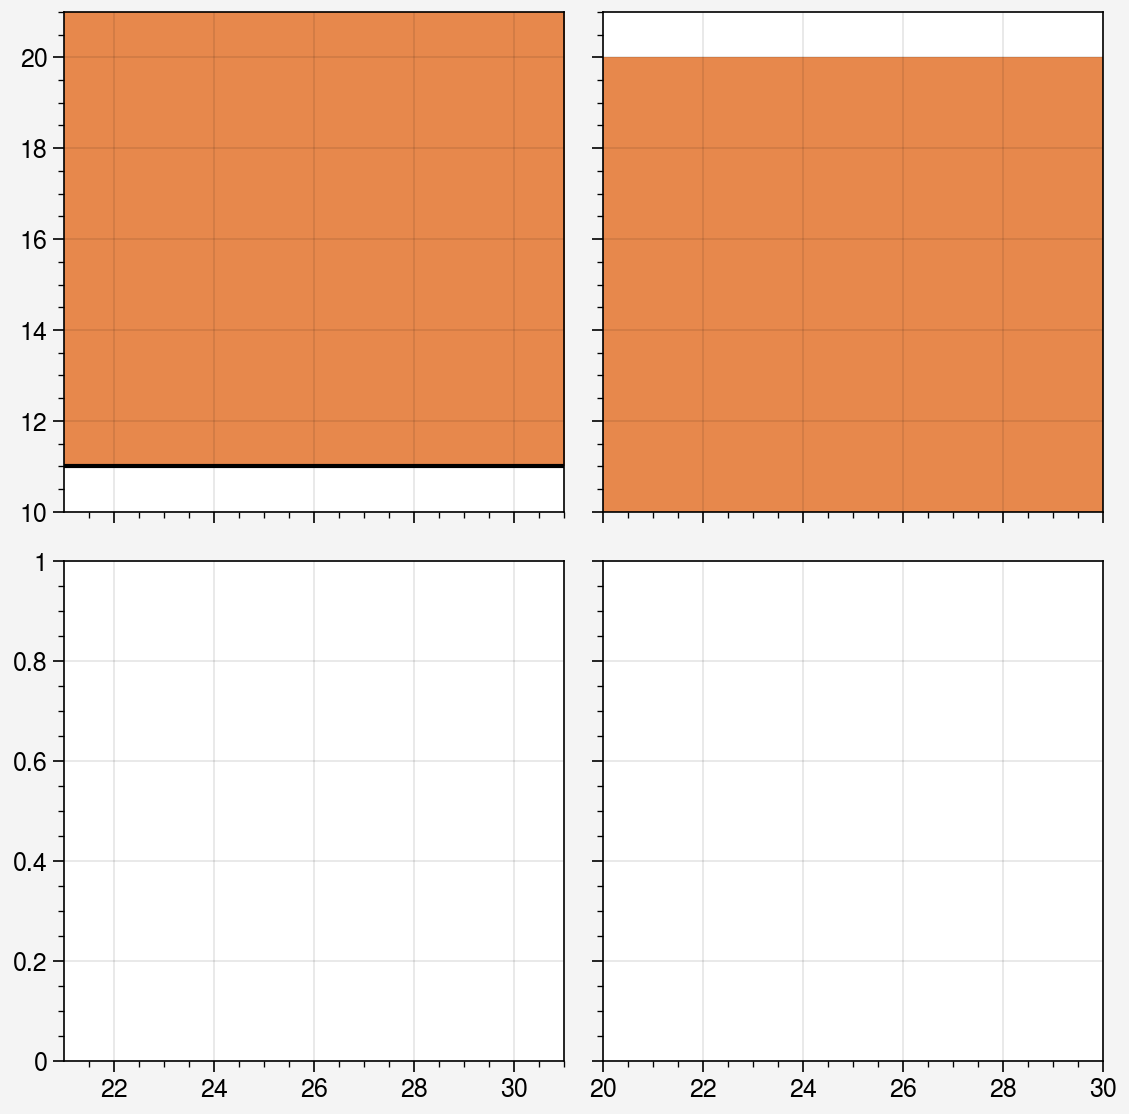

In [67]:
d = np.ones((10, 10))
x = np.linspace(20, 30, 11)
y = np.linspace(10, 20, 11)

fig, axs = pplt.subplots(nrows=2, ncols=2)

axs[0, 1].pcolorfast(x, y, d)
axs[0, 0].pcolorfast(x+1, y+1, d)
axs[0, 0].axhline(y[0]+1, color="k")

In [ ]:
np.floor(seasons).max()

In [ ]:
def calc_season(ra, mjd, mjd_start=None):
    """Calculate the 'season' in the survey for a series of ra/time values of an observation.
    Based only on the RA of the point on the sky, it calculates the 'season' based on when the sun
    passes through this RA (this marks the start of a 'season').

    Note that seasons should be calculated using the RA of a fixed point on the sky, such as
    the slice_point['ra'] if calculating season values for a series of opsim pointings on the sky.
    To convert to integer seasons, use np.floor(seasons)

    Parameters
    ----------
    ra : `float`
        The RA (in degrees) of the point on the sky
    mjd : `np.ndarray`
        The times of the observations, in MJD days

    Returns
    -------
    seasons : `np.array`
        The season values, as floats.
    """
    if mjd_start is None:
        mjd_start = survey_start_mjd()

    # A reference time and sun RA location to anchor the location of the Sun
    # This time was chosen as it is close to the expected start of the survey.
    ref_time = 60575.0
    ref_sun_ra = 179.20796047239727
    # Calculate the fraction of the sphere/"year" for this location
    offset = (ra - ref_sun_ra) / 360 * 365.25
    # Calculate when the seasons should begin
    season_began = ref_time + offset
    # Calculate the season value for each point.
    seasons = (mjd - season_began) / 365.25

    # Set reference zero season to RA=0, time=mjd_start
    offset_zero = (0 - ref_sun_ra) / 360 * 365.25
    season_began_zero = ref_time + offset_zero
    season_zero = (mjd_start - season_began_zero) / 365.25

    min_season = np.floor(season_zero)
    seasons = seasons - min_season
    return seasons

In [54]:
# from https://github.com/lsst/rubin_scheduler/blob/main/rubin_scheduler/utils/season_utils.py


def _compute_refs(mjd):
    # The reference values can be evaluated using:
    from astropy.time import Time
    from astropy.coordinates import get_sun
    from astropy.coordinates import EarthLocation
    loc = EarthLocation.of_site('Cerro Pachon')
    t = Time(mjd, format="mjd", location=loc)
    return get_sun(t).ra.deg, t.utc.mjd
    # return 0, t.utc.mjd
    # print('Ref time', t.utc.mjd)
    # print('Ref sun RA', get_sun(t).ra.deg, t.utc.mjd)
    # print('local sidereal time at season start', t.sidereal_time('apparent').deg)


def _calc_season_no_norm(ra, time, ref_time, ref_sun_ra):
    # Calculate the fraction of the sphere/"year" for this location
    offset = (ra - ref_sun_ra) / 360 * 365.25
    # Calculate when the seasons should begin
    season_began = ref_time + offset
    # Calculate the season value for each point.
    seasons = (time - season_began) / 365.25
    # (usually) Set first season at this point to 0
    return seasons


def calc_season_matt(ra, time, mjd_start=None):
    """Calculate the 'season' in the survey for a series of ra/time values of an observation.
    Based only on the RA of the point on the sky, it calculates the 'season' based on when the sun
    passes through this RA (this marks the start of a 'season').

    Note that seasons should be calculated using the RA of a fixed point on the sky, such as
    the slice_point['ra'] if calculating season values for a series of opsim pointings on the sky.
    To convert to integer seasons, use np.floor(seasons)

    Parameters
    ----------
    ra : `float`
        The RA (in degrees) of the point on the sky
    time : `np.ndarray`
        The times of the observations, in MJD days

    Returns
    -------
    seasons : `np.array`
        The season values, as floats.
    """
    if mjd_start is None:
        mjd_start = survey_start_mjd()

    ref_sun_ra, ref_time = 220, mjd_start
    
    # # A reference time and sun RA location to anchor the location of the Sun
    # # This time was chosen as it is close to the expected start of the survey.
    # ref_time = 60575.0
    # ref_sun_ra = 179.20796047239727

    # Calculate the fraction of the sphere/"year" for this location
    seasons = _calc_season_no_norm(ra, time, ref_time, ref_sun_ra)
    ref_season = np.min(np.floor(_calc_season_no_norm(
        220 + 10,
        mjd_start, 
        ref_time, 
        ref_sun_ra,
    )))

    seasons = seasons - ref_season
    return seasons
    # The reference values can be evaluated using:
    # from astropy.time import Time
    # from astropy.coordinates import get_sun
    # from astropy.coordinates import EarthLocation
    # loc = EarthLocation.of_site('Cerro Pachon')
    # t = Time('2024-09-22T00:00:00.00', format='isot', scale='utc', location=loc)
    # print('Ref time', t.utc.mjd)
    # print('Ref sun RA', get_sun(t).ra.deg, t.utc.mjd)
    # print('local sidereal time at season start', t.sidereal_time('apparent').deg)


# def _calc_season_no_norm(ra, time, ref_time, ref_sun_ra):
#     # Calculate the fraction of the sphere/"year" for this location
#     offset = (ra - ref_sun_ra) / 360 * 365.25
#     # Calculate when the seasons should begin
#     season_began = ref_time + offset
#     # Calculate the season value for each point.
#     seasons = (time - season_began) / 365.25
#     # (usually) Set first season at this point to 0
#     return seasons
#     # The reference values can be evaluated using:
#     # from astropy.time import Time
#     # from astropy.coordinates import get_sun
#     # from astropy.coordinates import EarthLocation
#     # loc = EarthLocation.of_site('Cerro Pachon')
#     # t = Time('2024-09-22T00:00:00.00', format='isot', scale='utc', location=loc)
#     # print('Ref time', t.utc.mjd)
#     # print('Ref sun RA', get_sun(t).ra.deg, t.utc.mjd)
#     # print('local sidereal time at season start', t.sidereal_time('apparent').deg)


# def calc_season_matt(ra, time, eps=1):
#     """Calculate the 'season' in the survey for a series of ra/time values of an observation.
#     Based only on the RA of the point on the sky, it calculates the 'season' based on when the sun
#     passes through this RA (this marks the start of a 'season').

#     Note that seasons should be calculated using the RA of a fixed point on the sky, such as
#     the slice_point['ra'] if calculating season values for a series of opsim pointings on the sky.
#     To convert to integer seasons, use np.floor(seasons)

#     Parameters
#     ----------
#     ra : `float`
#         The RA (in degrees) of the point on the sky
#     time : `np.ndarray`
#         The times of the observations, in MJD days

#     Returns
#     -------
#     seasons : `np.array`
#         The season values, as floats.
#     """
#     # A reference time and sun RA location to anchor the location of the Sun
#     # This time was chosen as it is close to the expected start of the survey.
#     ref_time = 60575.0
#     ref_sun_ra = 179.20796047239727
#     season = _calc_season_no_norm(ra, time, ref_time, ref_sun_ra)
    
#     min_season = min(
#         np.floor(_calc_season_no_norm(ref_sun_ra+eps, ref_time, ref_time, ref_sun_ra)),
#         np.floor(_calc_season_no_norm(ref_sun_ra-eps, ref_time, ref_time, ref_sun_ra)),
#     )
    
#     return season - min_season

In [ ]:
dt = 360 + 75
start_time = 60575.0
print(
    calc_season(np.array([10]), start_time+dt),
    calc_season(np.array([270]), start_time+dt),
    calc_season(np.array([10, 270]), start_time+dt),
)

In [ ]:
dt = 360 + 75
start_time = 60575.0
print(
    calc_season(np.array([10]), start_time+dt),
    calc_season(np.array([10]), start_time+4.2*dt),
    calc_season(np.array([10]), np.array([start_time+dt, start_time+4.2*dt])),
)

In [ ]:
dt = 360 + 75
start_time = 60575.0
print(
    calc_season(np.array([10]), start_time+4.2*dt, eps=1e-6),
    calc_season(np.array([10]), start_time+4.2*dt, eps=1),
    calc_season(np.array([10]), start_time+4.2*dt, eps=1e3),
)